<a href="https://colab.research.google.com/github/pacesatuinineh/Gaussian-Blur/blob/main/Komb3Mobilenet4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install efficientnet==0.0.3
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.7 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
#from efficientnet.tfkeras import EfficientNetB0
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import pywt

import random
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
# Paths
data_path = "/content/drive/MyDrive/modifdataset"  # Adjust the path to where 'papua-1' and 'papua-2' are located



In [5]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100

In [6]:
# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Histogram equalization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    # Apply noise reduction
    image = cv2.fastNlMeansDenoising(image, h=10)
    # Convert back to RGB
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [7]:
def apply_haar_wavelet_and_gaussian(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    LL_gaussian = cv2.GaussianBlur(LL, (5, 5), 0)  # Apply Gaussian filter
    return LL_gaussian  # Use the low-frequency component with Gaussian filter

In [8]:
# Function to apply Haar wavelet transformation
def apply_haar_wavelet(image):
    I = image.astype(float)
    m, n = I.shape[:2]
    if m % 2 != 0:
        m -= 1
    if n % 2 != 0:
        n -= 1
    I = I[:m, :n]

    LL = np.zeros((m // 2, n // 2))
    for i in range(0, m, 2):
        for j in range(0, n, 2):
            Ixy = I[i:i + 2, j:j + 2]
            LL[i // 2, j // 2] = np.mean(Ixy)
    return LL

In [9]:
# Function to extract HOG features
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [10]:
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)

                    # Apply Haar wavelet
                    #haar_image = apply_haar_wavelet(image)

                    #Resize the image to 224x224 for ResNet50
                    ##haar_image = apply_haar_wavelet_and_gaussian(haar_image)

                    # Extract HOG features
                    #hog_features = extract_hog_features(haar_image)

                    # Extract Gabor features
                    #gabor_features = extract_gabor_features(image)


                    #Extract Haar + Gabor
                    #combined_features = np.concatenate([haar_image.flatten(), gabor_features])

                    # 1. Gaussian Smoothing
                    gaussian_image = cv2.GaussianBlur(image, (5, 5), 0)

                    # 2. Haar Wavelet (Modified for 3 channels)
                    haar_image_LL = apply_haar_wavelet_and_gaussian(gaussian_image[:,:,0]) #Channel R
                    haar_image_LH = apply_haar_wavelet_and_gaussian(gaussian_image[:,:,1]) #Channel G
                    haar_image_HL = apply_haar_wavelet_and_gaussian(gaussian_image[:,:,2]) #Channel B
                    haar_image = np.stack([haar_image_LL,haar_image_LH, haar_image_HL], axis=-1)
                    haar_image = cv2.resize(haar_image.astype(np.uint8), IMAGE_SIZE)

                    # 3. HOG Features (on the 3-channel Haar output)
                    hog_features = extract_hog_features(haar_image)

                    data.append(hog_features)  # Append the processed image

                    #data.append(combined_features)  # Append the processed image

                    labels.append(folder)

    return np.array(data), np.array(labels)

In [11]:
# Load dataset
data, labels = load_data(data_path)

In [12]:
num_images_to_display = 4  # Jumlah gambar yang ingin ditampilkan
sample_images = data[:num_images_to_display]
sample_labels = labels[:num_images_to_display]

In [13]:
#fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))  # Sesuaikan figsize jika perlu
#for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
#    axes[i].imshow(image.astype(np.uint8), cmap='gray')
#    axes[i].axis('off')
#    axes[i].set_title(label)  # Menampilkan label sebagai judul di bawah gambar
#plt.show()

In [14]:
# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)


In [15]:
# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)


In [16]:
# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))


In [17]:
# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    #base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    #base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)  # Ganti ResNet50 dengan EfficientNetB
    #base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Tambahan lapisan
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Data augmentation
train_datagen = ImageDataGenerator(
    #rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.5,
    #zoom_range=0.5,
    #horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    #fill_mode='nearest'
)

In [19]:
test_datagen = ImageDataGenerator()

In [20]:
# Load and preprocess images for CNN
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)


In [21]:
train_images, train_labels = load_and_preprocess_images(data_path)
test_images, test_labels = load_and_preprocess_images(data_path)


In [22]:
# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [23]:
# Fit the model
history = model.fit(
    train_datagen.flow(train_images, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_images, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 997ms/step - accuracy: 0.2092 - loss: 15.5539 - val_accuracy: 0.2083 - val_loss: 13.9553 - learning_rate: 1.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.1945 - loss: 14.7333 - val_accuracy: 0.2410 - val_loss: 13.7484 - learning_rate: 1.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.1885 - loss: 14.3468 - val_accuracy: 0.2358 - val_loss: 13.5822 - learning_rate: 1.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.2079 - loss: 14.1152 - val_accuracy: 0.2423 - val_loss: 13.4136 - learning_rate: 1.0000e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.2263 - loss: 13.6944 - val_accuracy: 0.2364 - val_loss: 13.2513 - learning_rate: 1.0000e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.2223 - loss: 13.5224 - val_accuracy: 0.2279 - val_loss: 13.0879 - learning_rate: 1.0000e-04
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/ste

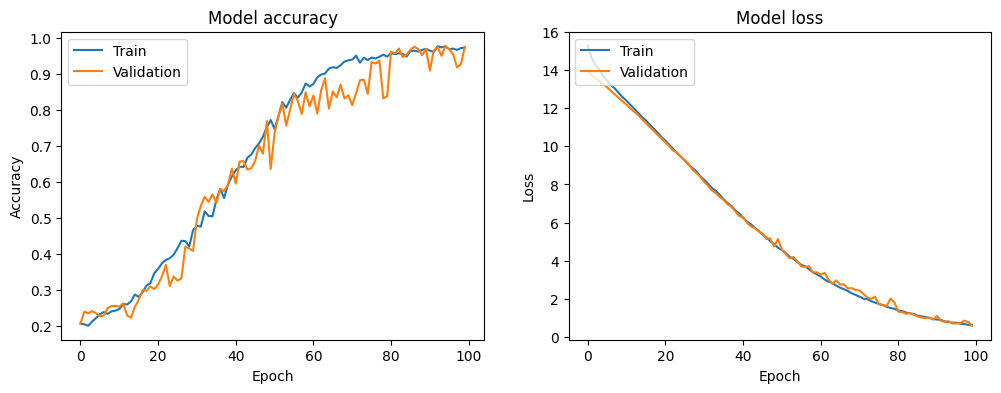

In [24]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step
              precision    recall  f1-score   support

     Aitinyo       1.00      0.94      0.97       374
     Ayamaru       0.95      0.98      0.97       311
      Kokoda       1.00      0.99      1.00       302
         Moi       0.96      0.98      0.97       301
       Tehit       0.96      1.00      0.98       239

    accuracy                           0.98      1527
   macro avg       0.97      0.98      0.98      1527
weighted avg       0.98      0.98      0.98      1527



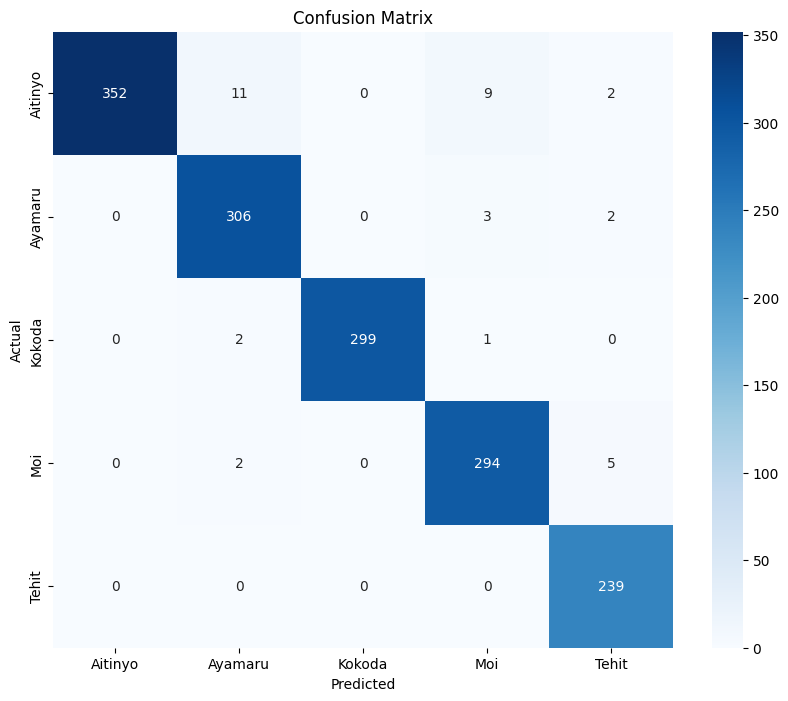

In [25]:
# Evaluate model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels_encoded, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [32]:
import random
import matplotlib.pyplot as plt
import numpy as np

random_index = random.randint(0, len(test_images) - 1)
image = test_images[random_index]
true_label = test_labels[random_index]

prediction = model.predict(np.expand_dims(image, axis=0))[0]
predicted_class_index = np.argmax(prediction)
predicted_class_label = encoder.classes_[predicted_class_index]
confidence = prediction[predicted_class_index]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


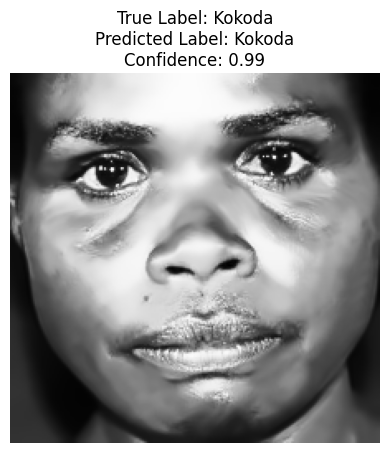

In [33]:
plt.imshow(image)
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_class_label}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

In [38]:
import numpy as np

def calculate_mse(original_image, predicted_image):
  """Menghitung MSE antara dua gambar."""
  mse = np.mean((original_image - predicted_image)**2)
  return mse

def calculate_psnr(original_image, predicted_image, max_pixel_value=255.0):
  """Menghitung PSNR antara dua gambar."""
  mse = calculate_mse(original_image, predicted_image)
  if mse == 0:
    psnr = float('inf')  # PSNR tak terhingga jika MSE nol
  else:
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
  return psnr

# Dapatkan gambar asli
original_image = test_images[random_index]

# Lakukan prediksi menggunakan model
prediction = model.predict(np.expand_dims(original_image, axis=0))[0]
predicted_class_index = np.argmax(prediction)
predicted_class_label = encoder.classes_[predicted_class_index]

# Ganti predicted_image dengan gambar yang diprediksi
#predicted_image = model.predict(np.expand_dims(original_image, axis=0))[0]  # Sesuaikan dengan output model
predicted_image = original_image

mse = calculate_mse(original_image, predicted_image)
psnr = calculate_psnr(original_image, predicted_image)

print(f"MSE: {mse:.2f}")
print(f"PSNR: {psnr:.2f} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MSE: 0.00
PSNR: inf dB
